In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from utils import make_spiral, plot_data, plot_decision_boundary, plot_training_progress, plot_decision_boundary_roundwise

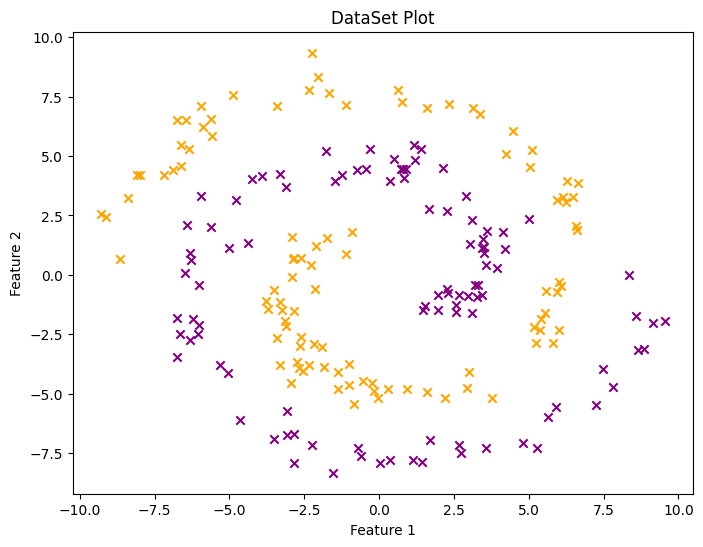

In [2]:
# Generate and plot the dataset
X, y = make_spiral(n_samples=100)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
plot_data(X, y)

## Q1:
*Implement and train a neural network on the dataset generated above. You are free to use any network architecture you think is useful. Finally, plot the decision boundary generated by your model.*

- The training of a neural network can be devided into the following steps:
1. Initialization of the parameters W[1], b[1], W[2], b[2], . . .
2. Computation of the forward pass
(i. e. compute the activations of the network for a batch of training examples)
3. Evaluate the loss function based on the true labels
4. Propagate the error gradients backwards through the network and update the
parameters (this step is referred to as backpropagation)
5. Update the weights using the gradient descent update rule
- Steps (2) to (5) are repeated until the network performs satisfactorily or until a fixed
number of iterations specified in advance has been performed

<div class="alert alert-block alert-success">
<b>Up to you:</b> Using the correct Resources for Trining could improve the Trainin Speed and Performance of the Model.
</div>

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [4]:
# Step 3: Define Dataset and DataLoader
class SpiralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SpiralDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

**Dataset-Klasse:**
- Diese Klasse dient dazu, den Datensatz in einer Art Container zu verpacken, den PyTorch dann verarbeiten kann.
- Die Klasse SpiralDataset erbt von torch.utils.data.Dataset, einer abstrakten Klasse, die genau die zwei Methoden __len__() und __getitem__() implementiert.
- __init__() wird verwendet, um die Daten (Features X und Labels y) zu speichern, wobei sie in Torch-Tensoren umgewandelt werden, was notwendig ist, um sie in PyTorch weiter bearbeiten zu können.
- __len__() gibt die Anzahl der Datenpunkte im Datensatz zurück.
- __getitem__() gibt einen einzelnen Datenpunkt zurück, bestehend aus einem Feature-Vektor und einem Label, basierend auf einem gegebenen Index.

**DataLoader:**
- Der DataLoader ist verantwortlich für das Laden von Daten in Batches und das Shufflen der Daten, falls erwünscht.
- PyTorch's *DataLoader* übernimmt die Aufgabe, die Daten effizient zu laden und stapelweise zu verarbeiten, wodurch das Training beschleunigt wird.
- *DataLoader(dataset, batch_size=32, shuffle=True)* erstellt einen DataLoader, der die Daten aus dem dataset in Batches von 32 Beispielpunkten lädt und die Daten vor jedem Epoche-Training mischt.

### **Step 1: Design the Model and intialize the Parameters**

In [5]:
# Step 4: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer_1 = nn.Linear(2, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 2)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.softmax(self.output_layer(x))
        return x

**Alternative: Pipeline-Architektur**

Eine alternative Methode ist die Verwendung von nn.Sequential, um eine Pipeline-Architektur zu definieren. nn.Sequential erlaubt es, die Layer eines Modells in der Reihenfolge zu spezifizieren, in der die Daten durch diese fließen, ohne eine explizite forward()-Methode zu definieren:

In [6]:
# model = nn.Sequential(
# nn.Linear(2, 10),
# nn.ReLU(),
# nn.Linear(10, 10),
# nn.ReLU(),
# nn.Linear(10, 2)
# )

In [7]:
# Step 5: Instantiate the model, define the loss function and optimizer
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
# Perfrom one forward pass to check the model:
with torch.no_grad():
    sample_input = torch.tensor(X[:5], dtype=torch.float32)
    sample_output = model(sample_input)
    labels = torch.argmax(sample_output, dim=1)
    #criterion_output = criterion(sample_output, torch.tensor([0], dtype=torch.long))
    print(f"Sample input: {sample_input}, Sample output: {sample_output}, Resulting Label: {labels}" )#, Loss: {criterion_output.item()}")

Sample input: tensor([[-1.7769,  5.2217],
        [ 8.6473, -3.1784],
        [-2.2482, -7.1489],
        [-6.6416, -2.4775],
        [ 4.2191,  1.0704]]), Sample output: tensor([[0.4848, 0.5152],
        [0.4788, 0.5212],
        [0.4760, 0.5240],
        [0.4747, 0.5253],
        [0.4930, 0.5070]]), Resulting Label: tensor([1, 1, 1, 1, 1])


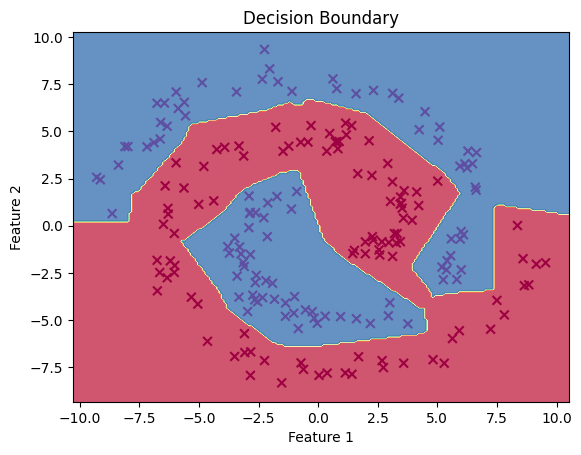

In [13]:
plot_decision_boundary(model, X, y)

## Step 6: ittearate the Training

In [10]:
def train_model(model, learning_rate=0.01, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=100, plot_interval=10):
    criterion = loss_fn()
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []

    # Set up for plotting
    num_plots = num_epochs // plot_interval
    fig, axes = plt.subplots(nrows=num_plots//2, ncols=2, figsize=(12, 6 * (num_plots//2)))

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = torch.argmax(y_pred, dim=1)
                correct += (predictions == batch_y).sum().item()

        train_loss.append(epoch_loss / len(dataloader))
        accuracy = correct / len(dataset)
        train_acc.append(accuracy * 100)

        # Plot interval
        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.2f}%")
            ax_index = (epoch // plot_interval) // 2, (epoch // plot_interval) % 2
            plot_decision_boundary_roundwise(model, X_tensor, y_tensor, axes[ax_index])

    # Plot final metrics with dual axes
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(train_loss, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Train Accuracy (%)', color=color)
    ax2.plot(train_acc, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and legends
    fig.suptitle('Training Loss and Accuracy')
    fig.tight_layout()  # For a cleaner layout
    plt.show()

    return model


Epoch [100/1000], Loss: 0.6297, Accuracy: 65.00%


/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils.py:97: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='plasma', s=40, marker='x')


Epoch [200/1000], Loss: 0.4729, Accuracy: 89.50%
Epoch [300/1000], Loss: 0.3985, Accuracy: 93.00%
Epoch [400/1000], Loss: 0.3584, Accuracy: 99.50%
Epoch [500/1000], Loss: 0.3390, Accuracy: 100.00%
Epoch [600/1000], Loss: 0.3294, Accuracy: 100.00%
Epoch [700/1000], Loss: 0.3260, Accuracy: 100.00%
Epoch [800/1000], Loss: 0.3217, Accuracy: 100.00%
Epoch [900/1000], Loss: 0.3194, Accuracy: 100.00%
Epoch [1000/1000], Loss: 0.3169, Accuracy: 100.00%


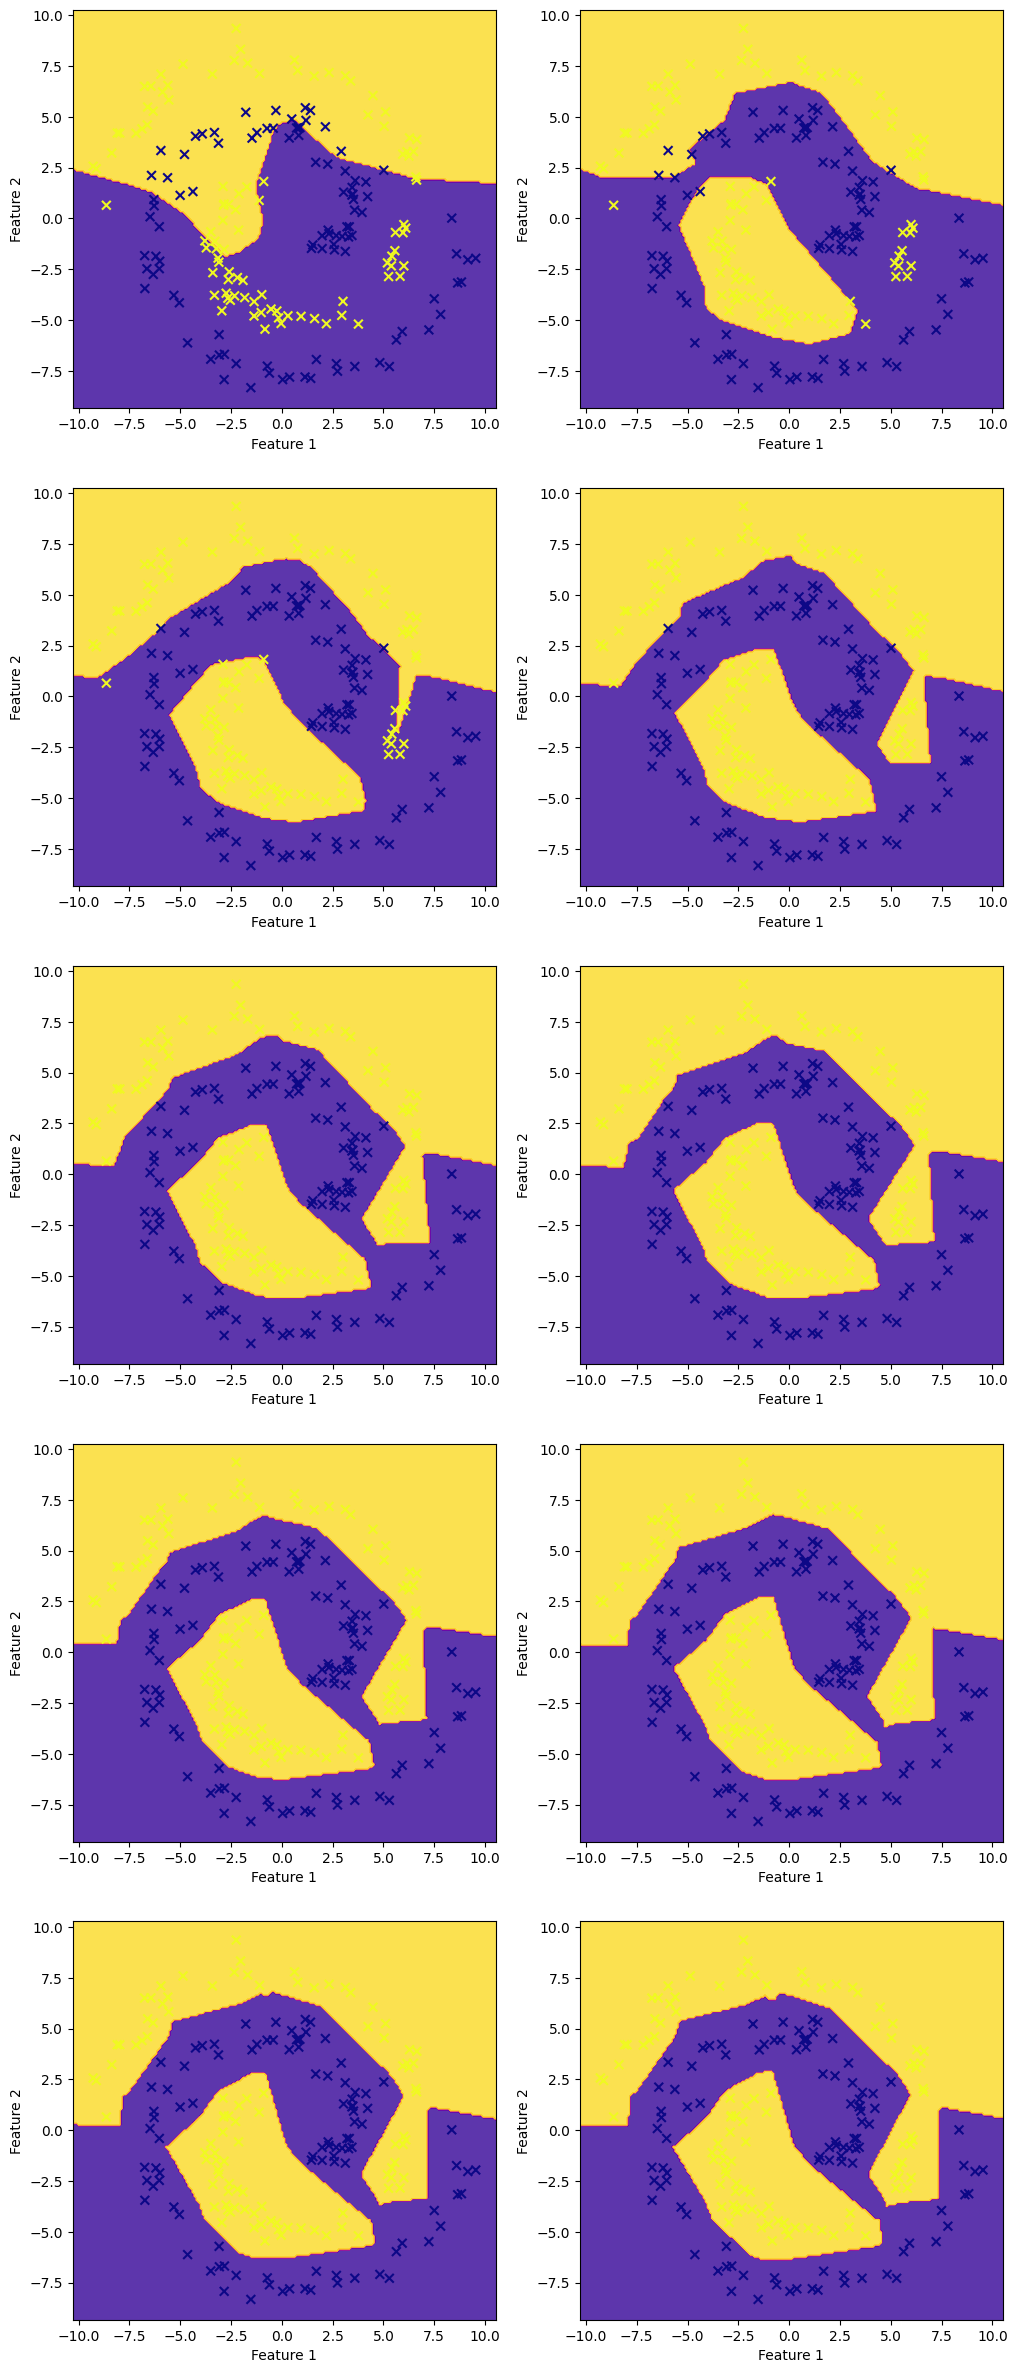

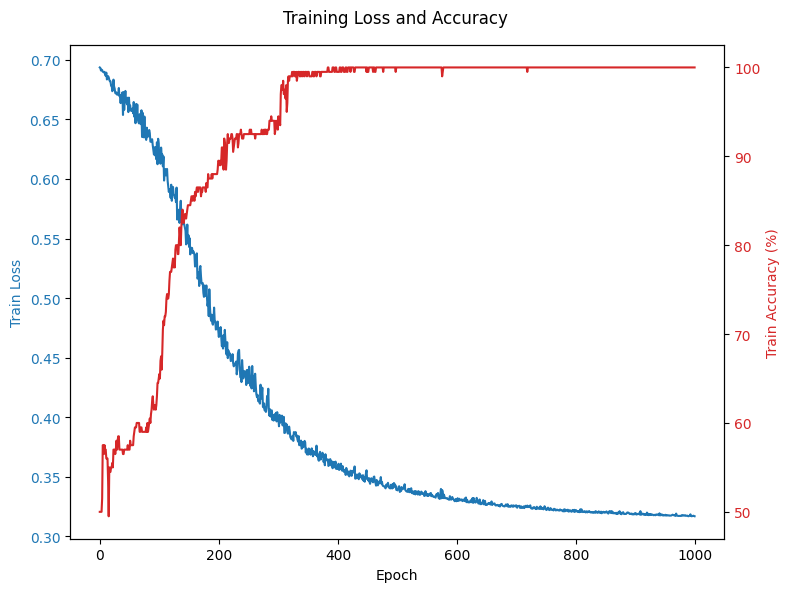

In [11]:
# Beispiel für das Training des Modells mit parametrisierten Inputs
model = train_model(model, learning_rate=0.001, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=1000, plot_interval=100)

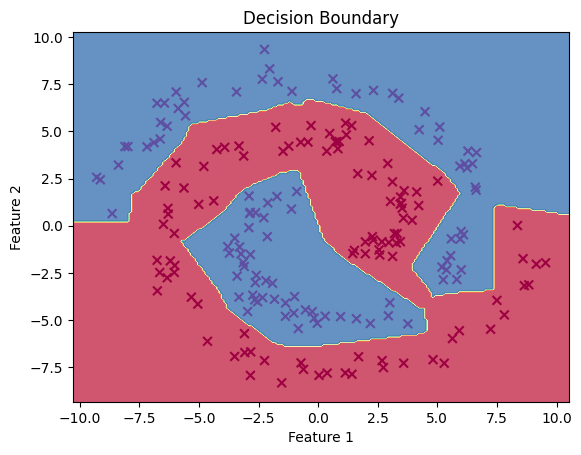

In [12]:
plot_decision_boundary(model, X, y)